## 全球经济主题类新闻中的国家共现关系
---
> Author: 罗晨

> 数据来自[GDELT 2.0 Global Knowledge Graph](http://data.gdeltproject.org/gdeltv2/masterfilelist.txt), 说明文档见[Documentation](http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.1.pdf)

> 数据每15分钟更新一次，数据下载路径形如：<br>
> `http://data.gdeltproject.org/gdeltv2/20150218230000.gkg.csv.zip`<br>
> 其中的`20150218230000`在下一次更新会变成`20150218231500`

### 00 - 导入基本模块

In [1]:
import os
import io
import time
import random
import requests
import itertools
import numpy as np
import pandas as pd
import datetime as dt
from collections import defaultdict

### 01 - 获取数据

In [2]:
# 存放数据路径，该文件夹需要事先建立
PATH = './Nov2017/'

# gkg网络路径前缀、后缀
URL = 'http://data.gdeltproject.org/gdeltv2/'
suffix = '.gkg.csv.zip'

In [3]:
# 设置获取gkg数据的起止时间
start_date = dt.datetime(2017, 11, 7)
end_date = dt.datetime(2017, 11, 13)

print start_date, '\n', end_date
print start_date.strftime('%Y%m%d%H%M%S')

2017-11-07 00:00:00 
2017-11-13 00:00:00
20171107000000


In [ ]:
# 下载数据
date = start_date

while date <= end_date:
    filename = date.strftime('%Y%m%d%H%M%S') + suffix
    try:
        req = requests.get(URL + filename)
        dl = io.open(PATH + filename, 'wb')
        for chunk in req.iter_content(chunk_size = 1024):
            if chunk:
                dl.write(chunk)
        dl.close()
        print 'downloaded...', '\t', URL + filename
    except:
        pass
    date += dt.timedelta(minutes = 15)
    # 善意请求，务必加上等待时间
    time.sleep(random.randint(10, 25))

### 02 - 数据格式

In [4]:
# 数据不包含字段名称，数据含义详细解释请查看说明文档
with open(PATH + '20171107004500.gkg.csv', 'r') as f:
    header = f.readline()
    print header.split('\t')

['20171107004500-0', '20171107004500', '1', 'iheart.com', 'https://rock967.iheart.com/content/2017-11-06-neighbors-forced-to-take-drastic-measures-after-bird-vandalizes-cars/', '', '', 'TAX_FNCACT;TAX_FNCACT_AUTHORITIES;CRISISLEX_CRISISLEXREC;EPU_POLICY;EPU_POLICY_AUTHORITIES;TAX_FNCACT_CULPRIT;TAX_FNCACT_CHILDREN;MEDIA_MSM;CRISISLEX_T11_UPDATESSYMPATHY;VANDALIZE;SECURITY_SERVICES;TAX_FNCACT_POLICE;CRISISLEX_C07_SAFETY;TAX_FNCACT_CRIMINAL;', 'CRISISLEX_T11_UPDATESSYMPATHY,423;TAX_FNCACT_CRIMINAL,641;TAX_FNCACT_CULPRIT,176;MEDIA_MSM,328;VANDALIZE,542;SECURITY_SERVICES,581;TAX_FNCACT_POLICE,581;CRISISLEX_C07_SAFETY,581;TAX_FNCACT_AUTHORITIES,109;CRISISLEX_CRISISLEXREC,109;EPU_POLICY_AUTHORITIES,109;TAX_FNCACT_CHILDREN,286;', '2#Georgia, United States#US#USGA#32.9866#-83.6487#GA;3#Snellville, Georgia, United States#US#USGA#33.8573#-84.0199#334004', '3#Snellville, Georgia, United States#US#USGA#GA135#33.8573#-84.0199#334004#123;3#Snellville, Georgia, United States#US#USGA#GA135#33.8573#-84

In [4]:
# 查看Locations，在第10列
# 用;分隔的#连接字符，连接成分包括：
# Location Type（整数）：1-Country, 2-USSTATE, 3-USCITY, 4-WorldCity（美国以外的城市）,5-WorldState（美国以外的与州对等的区划）
# 对于1、2、5提供几何中心的经纬度，本处只选取Country层面进行分析
# Location FullName（文本）：详细的地名，格式包括："State, Country"(for 2, 5), "City/Landmark, State, Country"(for 1, 3, 4)
# Location CountryCode（文本）：FIPS10-4国家代码，长度为2
# and so on
with open(PATH + '20171107004500.gkg.csv', 'r') as f:
    print f.readlines()[0].split('\t')[9].split(';')

['2#Georgia, United States#US#USGA#32.9866#-83.6487#GA', '3#Snellville, Georgia, United States#US#USGA#33.8573#-84.0199#334004']


In [5]:
# 查看主题，在第8列
with open(PATH + '20171107004500.gkg.csv', 'r') as f:
    print f.readlines()[0].split('\t')[7].split(';')

['TAX_FNCACT', 'TAX_FNCACT_AUTHORITIES', 'CRISISLEX_CRISISLEXREC', 'EPU_POLICY', 'EPU_POLICY_AUTHORITIES', 'TAX_FNCACT_CULPRIT', 'TAX_FNCACT_CHILDREN', 'MEDIA_MSM', 'CRISISLEX_T11_UPDATESSYMPATHY', 'VANDALIZE', 'SECURITY_SERVICES', 'TAX_FNCACT_POLICE', 'CRISISLEX_C07_SAFETY', 'TAX_FNCACT_CRIMINAL', '']


### 03 - 查找所有文件中包含“经济”主题且涉及“中国”的新闻

In [6]:
csvnames = os.listdir('./Nov2017')
len(csvnames)

154

In [7]:
# 下载的数据中共有30,993条新闻记录中涉及中国，其中存在的共现关系过多，因此对主题(themes)加以限定，选择的与经济相关的主题，特征是以"ECON"开头
includeCHN = open('includeCHN.txt', 'w')
_ = []

# 包含“经济”主题的新闻数：159,257
for csv in csvnames:
    with open(PATH + csv, 'r') as f:
        for line in f.readlines():
            try:
                themeField = line.split('\t')[7]
                if 'ECON' in themeField:
                    _.append(line.strip())
            except:
                pass
print len(_)

# 包含“经济”主题且涉及中国的新闻数：17,472
for news in set(_):
    try:
        locationField = news.split('\t')[9]
        if "china" in locationField.lower():
            includeCHN.write(locationField)
            includeCHN.write('\n')
    except:
        pass

includeCHN.close()

with open('includeCHN.txt', 'r') as f:
    print len(f.readlines())

159257
17472


### 04 - 查找与中国共现的国家 & 这些国家间存在的共现关系

In [8]:
states = []

with open('includeCHN.txt', 'r') as f:
    for line in f.readlines():
        lst = []
        locations = line.split(';')
        for location in locations:
            # 只选择国家，country code = 1
            if location.split('#')[0] == '1':
                lst.append(location.split('#')[1].strip())
        # 需要按照首字母顺序进行排序，避免后续出现组合重复
        lst.sort()
        states.append(lst)

In [9]:
# 检查国家名称是否与一带一路国家英文名称（存放在BRStates.xlsx中）相一致
# 如果存在不一致，需要修改BRStates，如：Vietnam: Vietnam, Republic Of | Korea: South Korea
states[0:20]

[['Australia',
  'Brazil',
  'China',
  'Mexico',
  'Spain',
  'Turkey',
  'United States'],
 ['Afghanistan',
  'China',
  'France',
  'India',
  'Pakistan',
  'United Kingdom',
  'United States'],
 ['China', 'India', 'Israel', 'Taiwan'],
 ['China', 'Japan', 'North Korea', 'Russia', 'South Korea', 'United States'],
 ['China', 'France', 'Portugal'],
 ['China', 'North Korea', 'Russia', 'South Korea', 'Syria', 'United States'],
 ['China',
  'Cuba',
  'France',
  'Japan',
  'North Korea',
  'Russia',
  'South Korea',
  'Taiwan',
  'United States'],
 [],
 ['China', 'India', 'Israel', 'Japan', 'United States'],
 ['Canada', 'Colombia', 'New Zealand', 'Sri Lanka', 'United States'],
 ['Australia',
  'Brazil',
  'China',
  'Germany',
  'Greece',
  'Indonesia',
  'Italy',
  'Japan',
  'Malaysia',
  'Mexico',
  'New Zealand',
  'Peru',
  'Philippines',
  'Poland',
  'Portugal',
  'Russia',
  'Saudi Arabia',
  'Singapore',
  'South Korea',
  'United States',
  'Venezuela',
  'Vietnam, Republic Of']

In [10]:
# 构建国家之间的组合
statePairwise = []
for i in states:
    statePairwise.append(list(itertools.combinations(i, 2)))
# peek，如果列表为空表示对应事件中仅仅出现了一个国家（中国）
statePairwise[:3]

[[('Australia', 'Brazil'),
  ('Australia', 'China'),
  ('Australia', 'Mexico'),
  ('Australia', 'Spain'),
  ('Australia', 'Turkey'),
  ('Australia', 'United States'),
  ('Brazil', 'China'),
  ('Brazil', 'Mexico'),
  ('Brazil', 'Spain'),
  ('Brazil', 'Turkey'),
  ('Brazil', 'United States'),
  ('China', 'Mexico'),
  ('China', 'Spain'),
  ('China', 'Turkey'),
  ('China', 'United States'),
  ('Mexico', 'Spain'),
  ('Mexico', 'Turkey'),
  ('Mexico', 'United States'),
  ('Spain', 'Turkey'),
  ('Spain', 'United States'),
  ('Turkey', 'United States')],
 [('Afghanistan', 'China'),
  ('Afghanistan', 'France'),
  ('Afghanistan', 'India'),
  ('Afghanistan', 'Pakistan'),
  ('Afghanistan', 'United Kingdom'),
  ('Afghanistan', 'United States'),
  ('China', 'France'),
  ('China', 'India'),
  ('China', 'Pakistan'),
  ('China', 'United Kingdom'),
  ('China', 'United States'),
  ('France', 'India'),
  ('France', 'Pakistan'),
  ('France', 'United Kingdom'),
  ('France', 'United States'),
  ('India', 'Pa

In [11]:
# 计算国家间共现次数
pairCount = defaultdict(int)
for i in statePairwise:
    if len(i) > 0:
        for j in i:
            pairCount[j] += 1
# 共存在12,390对国家共现关系
len(pairCount)

12390

### 05 - 筛选出共现国家中的一带一路沿线国家

In [12]:
BRStates = pd.read_excel('BRStates.xlsx', 
                         sheetname='Sheet1', 
                         header=0)
BRStates.head()

国家      Country
0    阿富汗  Afghanistan
1  阿尔巴尼亚      Albania
2   亚美尼亚      Armenia
3   阿塞拜疆   Azerbaijan
4     巴林      Bahrain

In [13]:
BRCountry = [i.lower() for i in list(BRStates['Country'])]
len(BRCountry)

69

In [14]:
# 一带一路的国家间存在1780对共现关系
for i in pairCount.items():
    if i[0][0].lower() not in BRCountry or i[0][1].lower() not in BRCountry:
        pairCount.pop(i[0])
len(pairCount)

1780

### 06 - 绘制网络

In [15]:
network = []
# 由于关系过多，绘制的网络图不清晰，选择共现数量超过50次的国家
for i in sorted(pairCount.items(), key = lambda x: x[1], reverse = True):
    network.append({'source': i[0][0], 'target': i[0][1], 'value': i[1]})
network = pd.DataFrame(network)
network = network[network['value'] >= 50]
network.head()

source                target  value
0   China           South Korea   3657
1   China                Russia   3545
2   China                 India   2305
3  Russia           South Korea   1904
4   China  Vietnam, Republic Of   1823

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

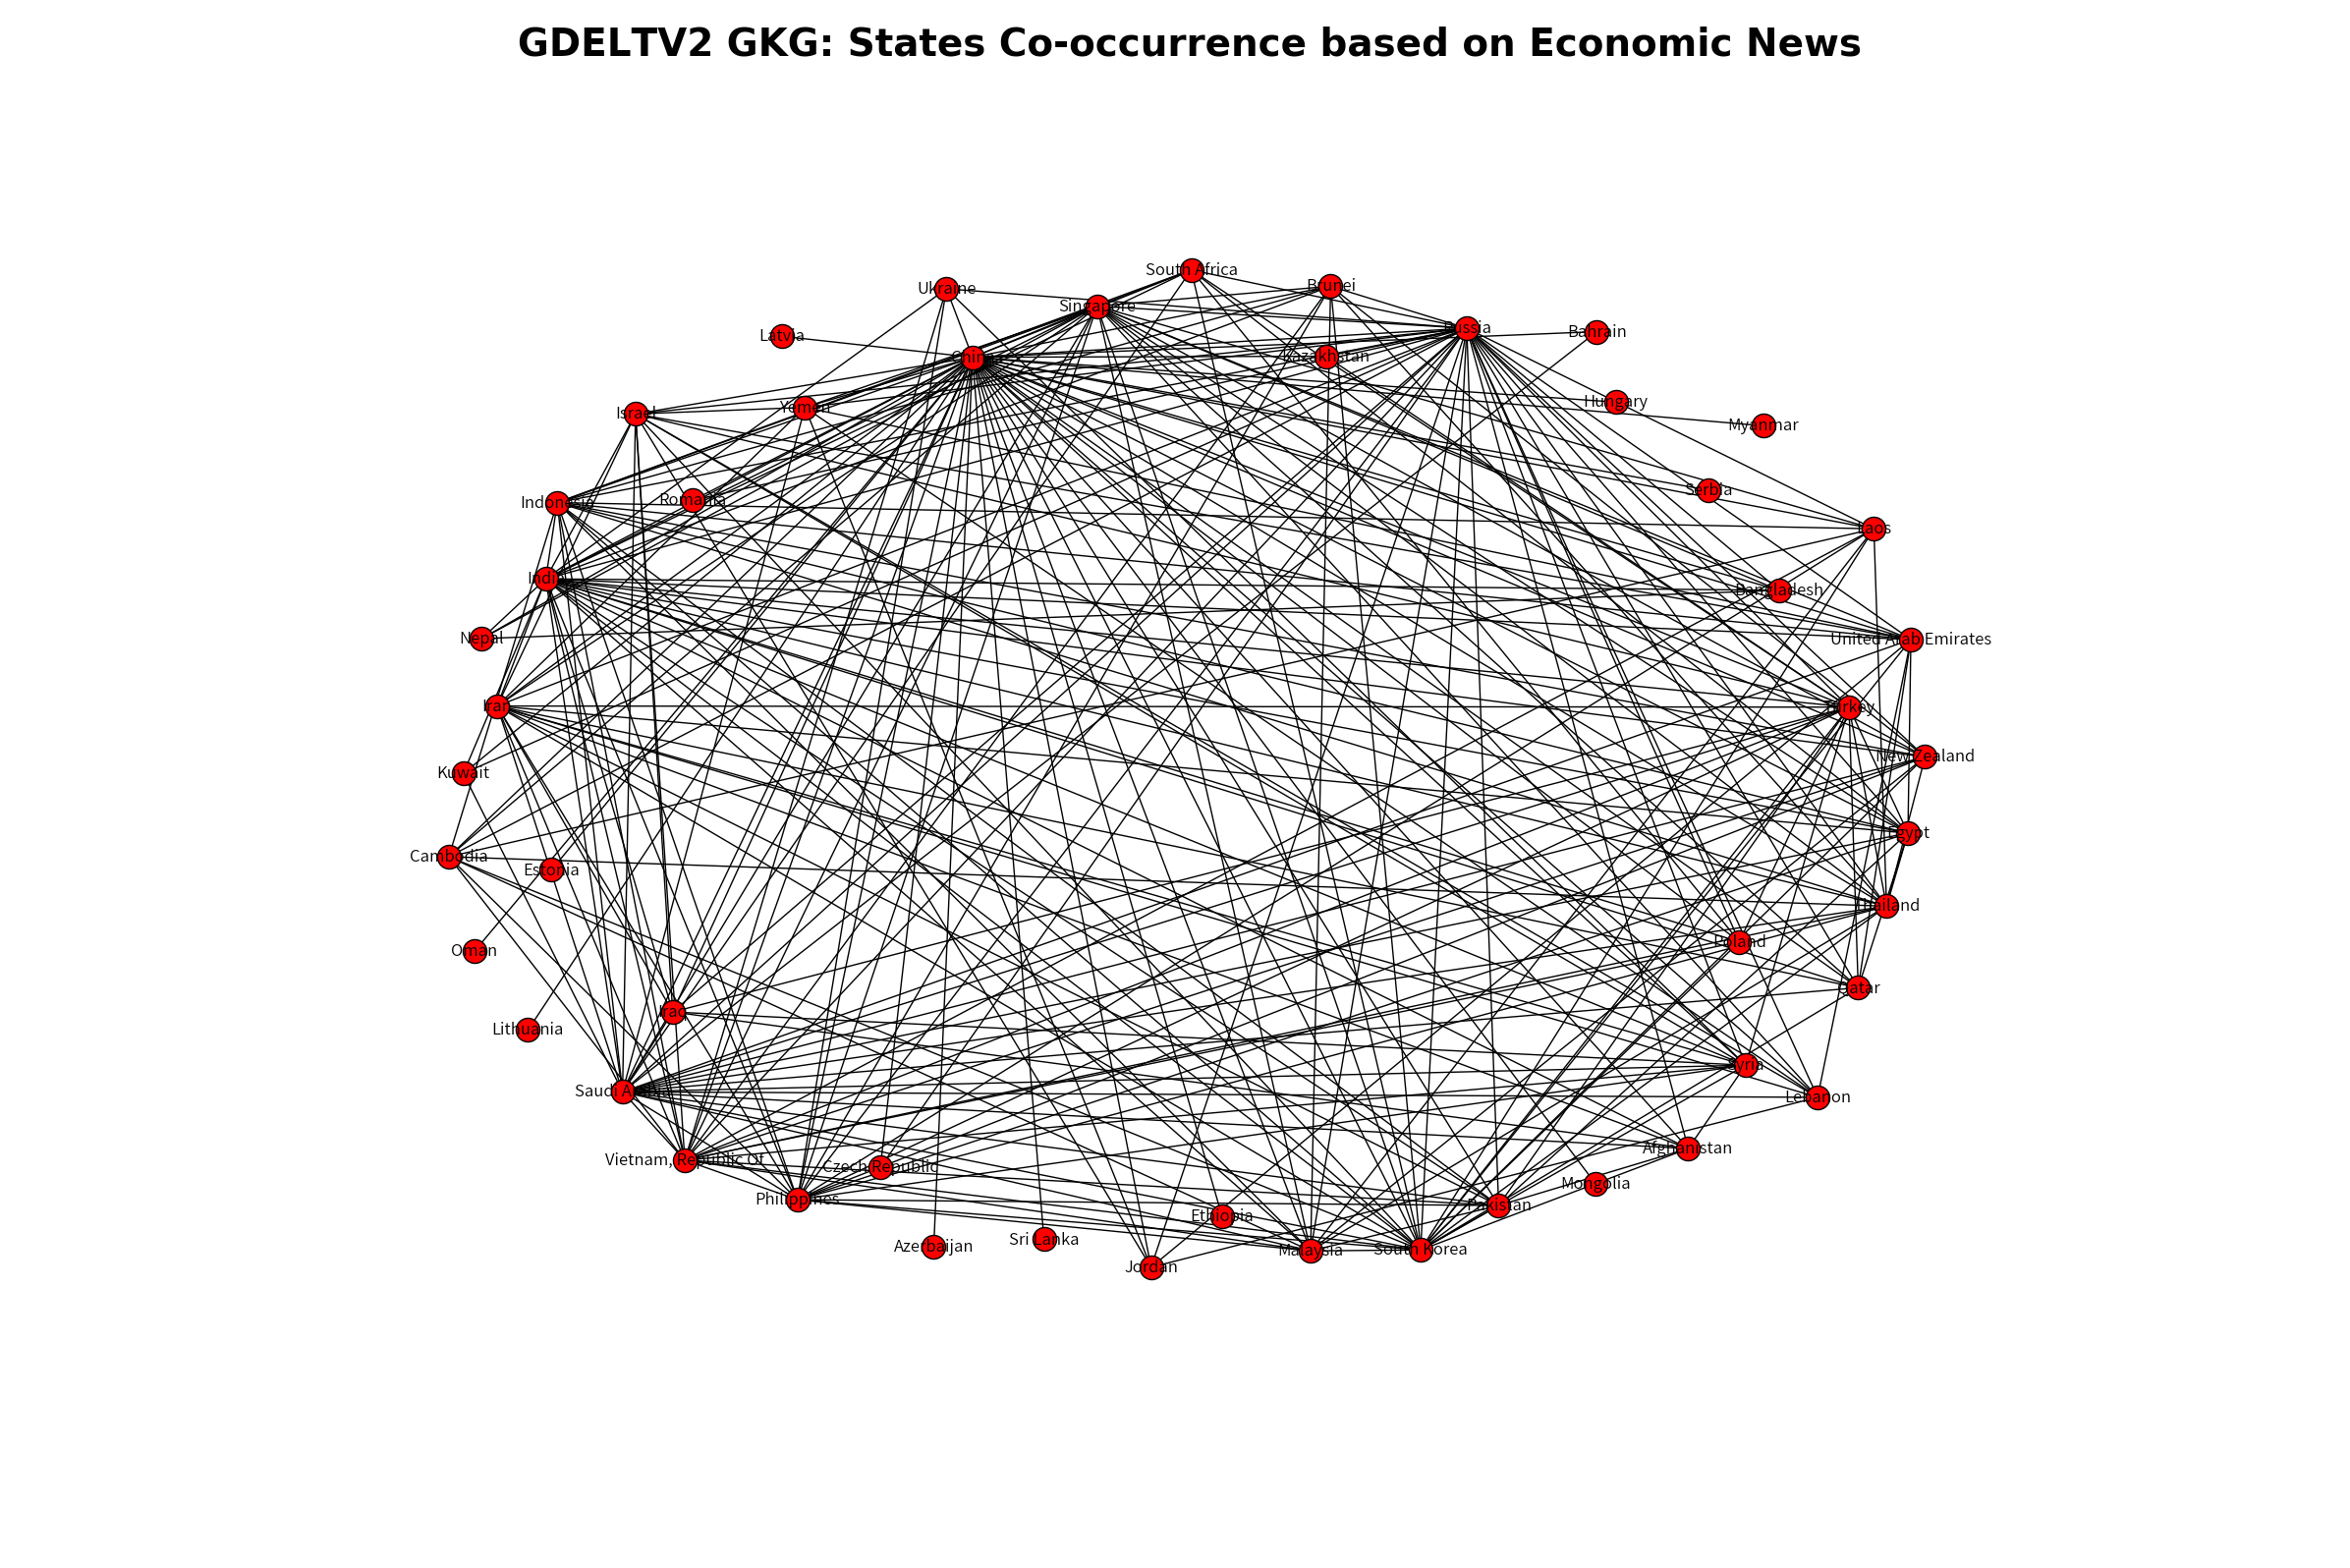

In [17]:
g = nx.Graph()
for r in network.values:
    g.add_edge(r[0], r[1], weight = r[2]/10000)
plt.figure(figsize=(30, 20))
plt.title('GDELTV2 GKG: States Co-occurrence based on Economic News', 
          y = 0.97, 
          fontsize = 28, 
          fontweight = 'bold')
nx.draw(g, with_labels=True)

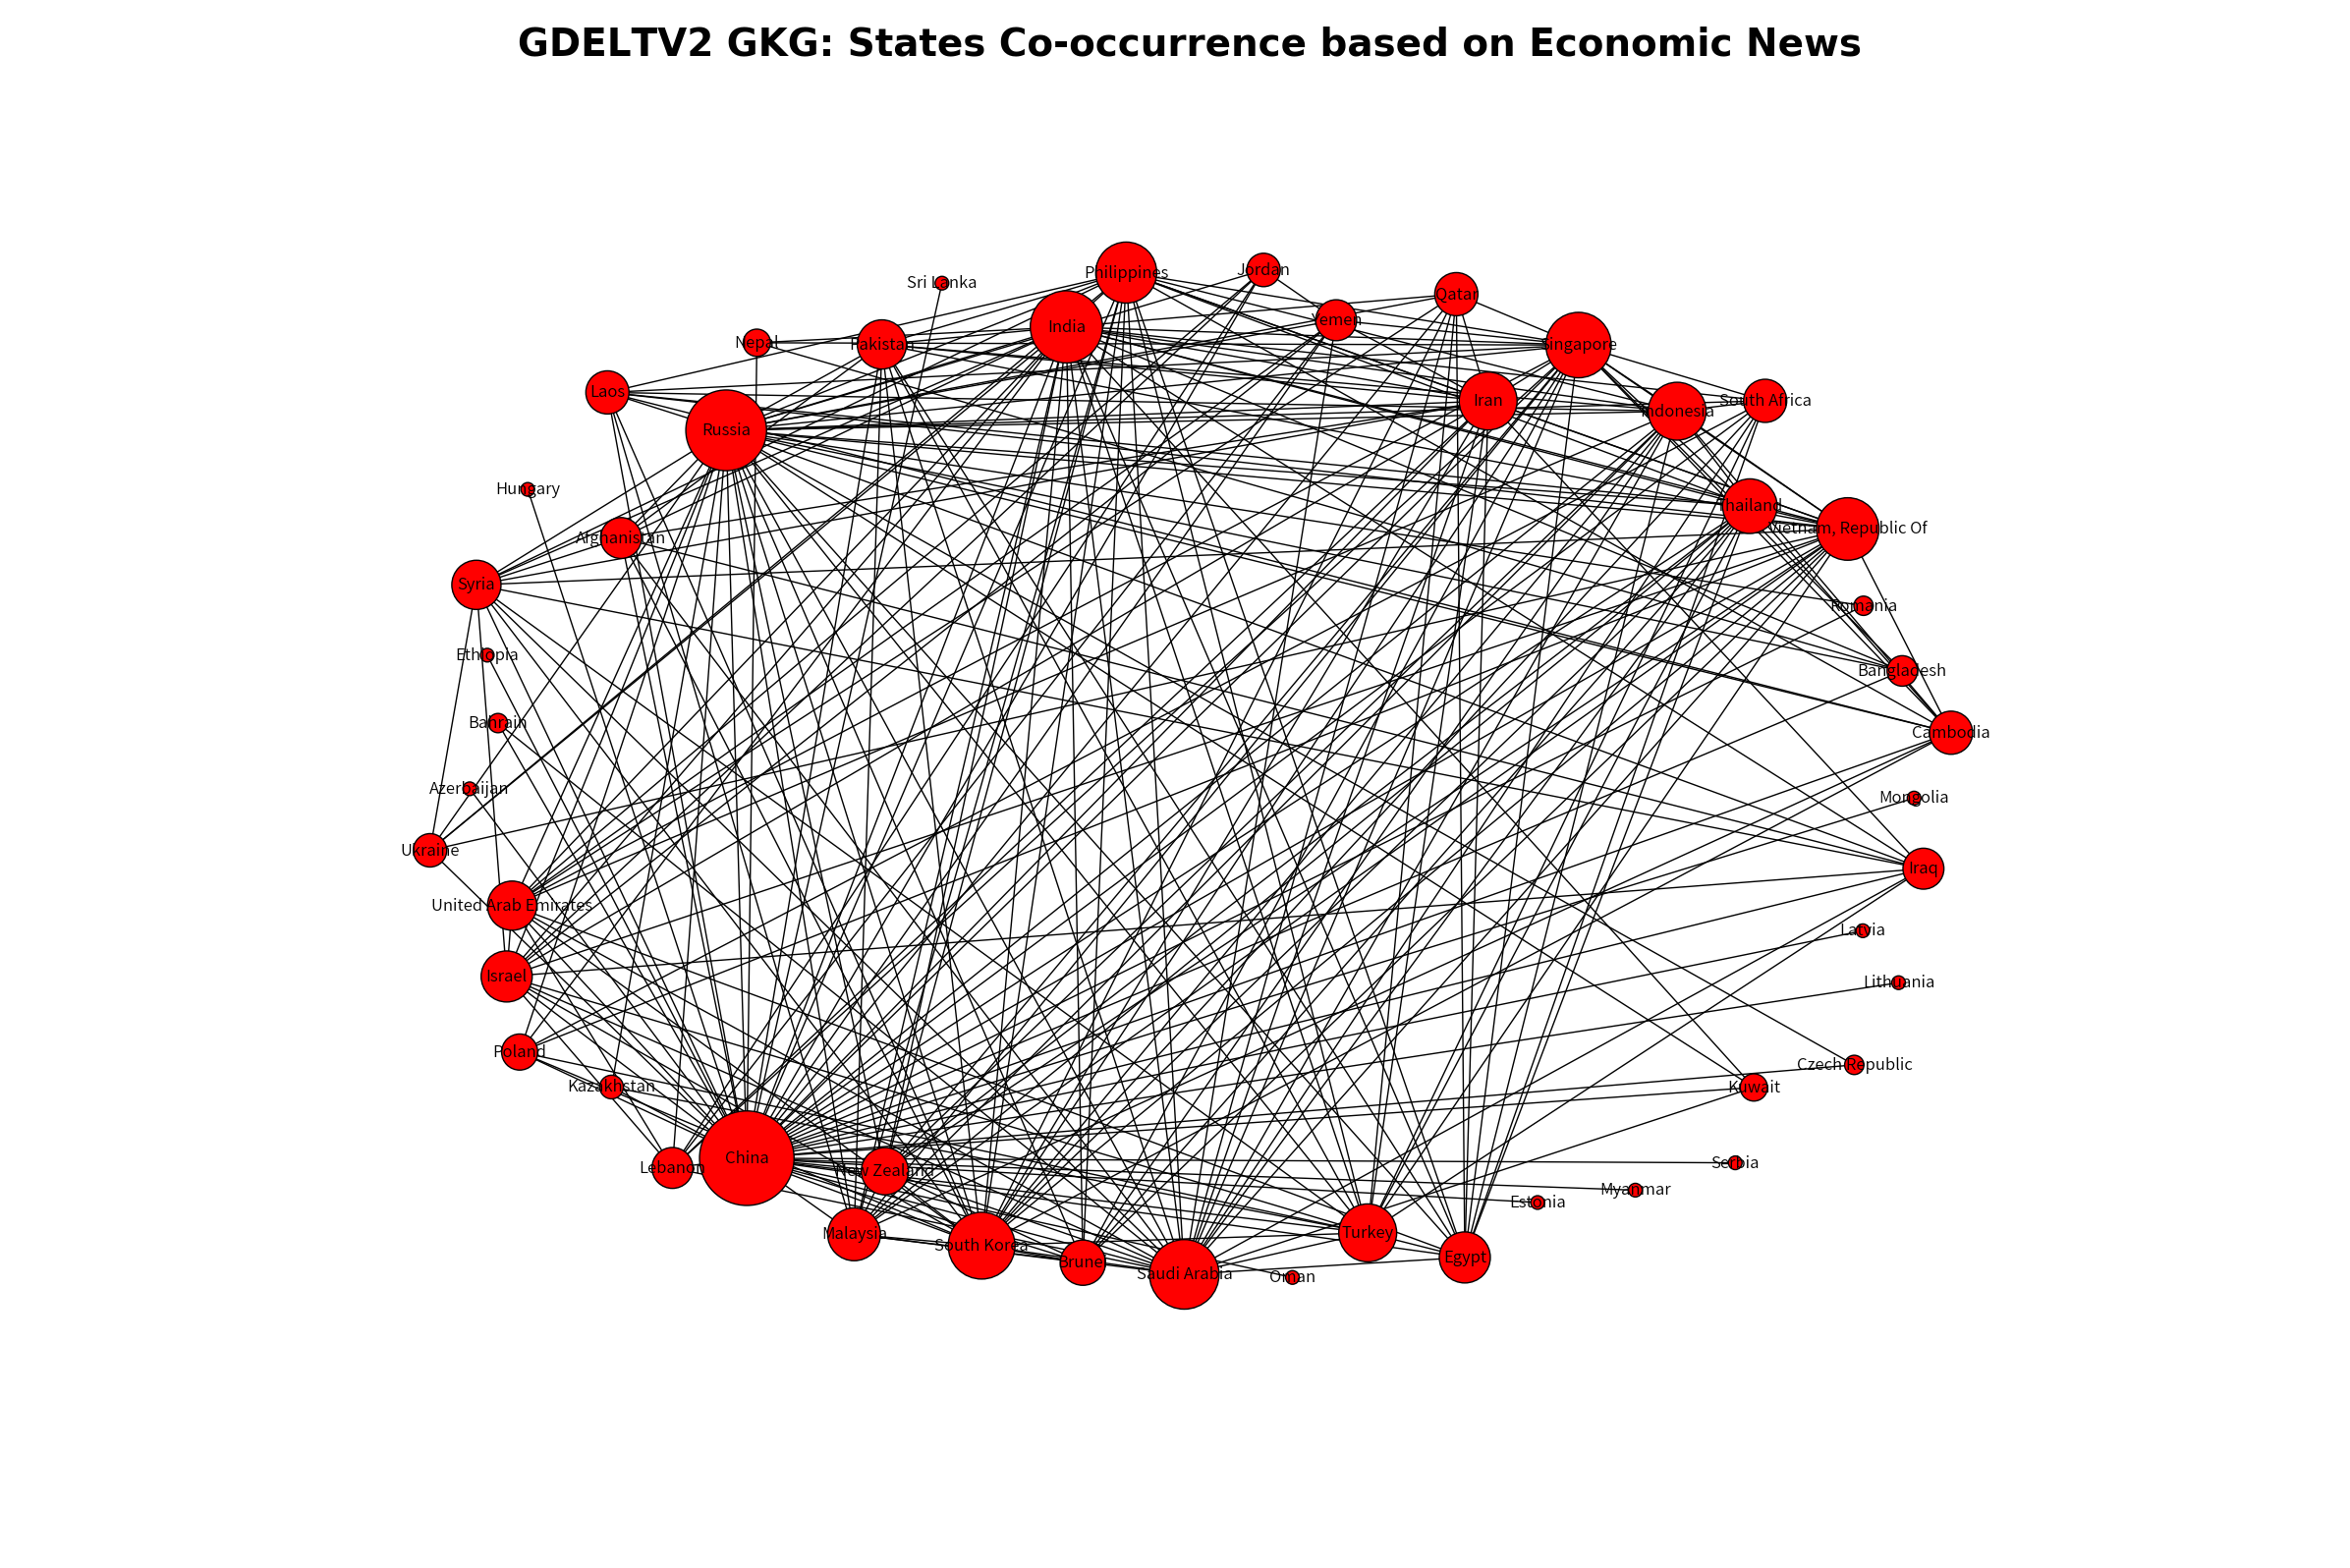

In [18]:
# 节点的大小与节点的度指标成正比
g = nx.Graph()
for r in network.values:
    g.add_edge(r[0], r[1], weight = r[2]/10000)
plt.figure(figsize=(30, 20))
plt.title('GDELTV2 GKG: States Co-occurrence based on Economic News', 
          y = 0.97, 
          fontsize = 28, 
          fontweight = 'bold')
d = dict(nx.degree(g))
nx.draw(g, nodelist = d.keys(), node_size = [v*100 for v in d.values()], with_labels = True)

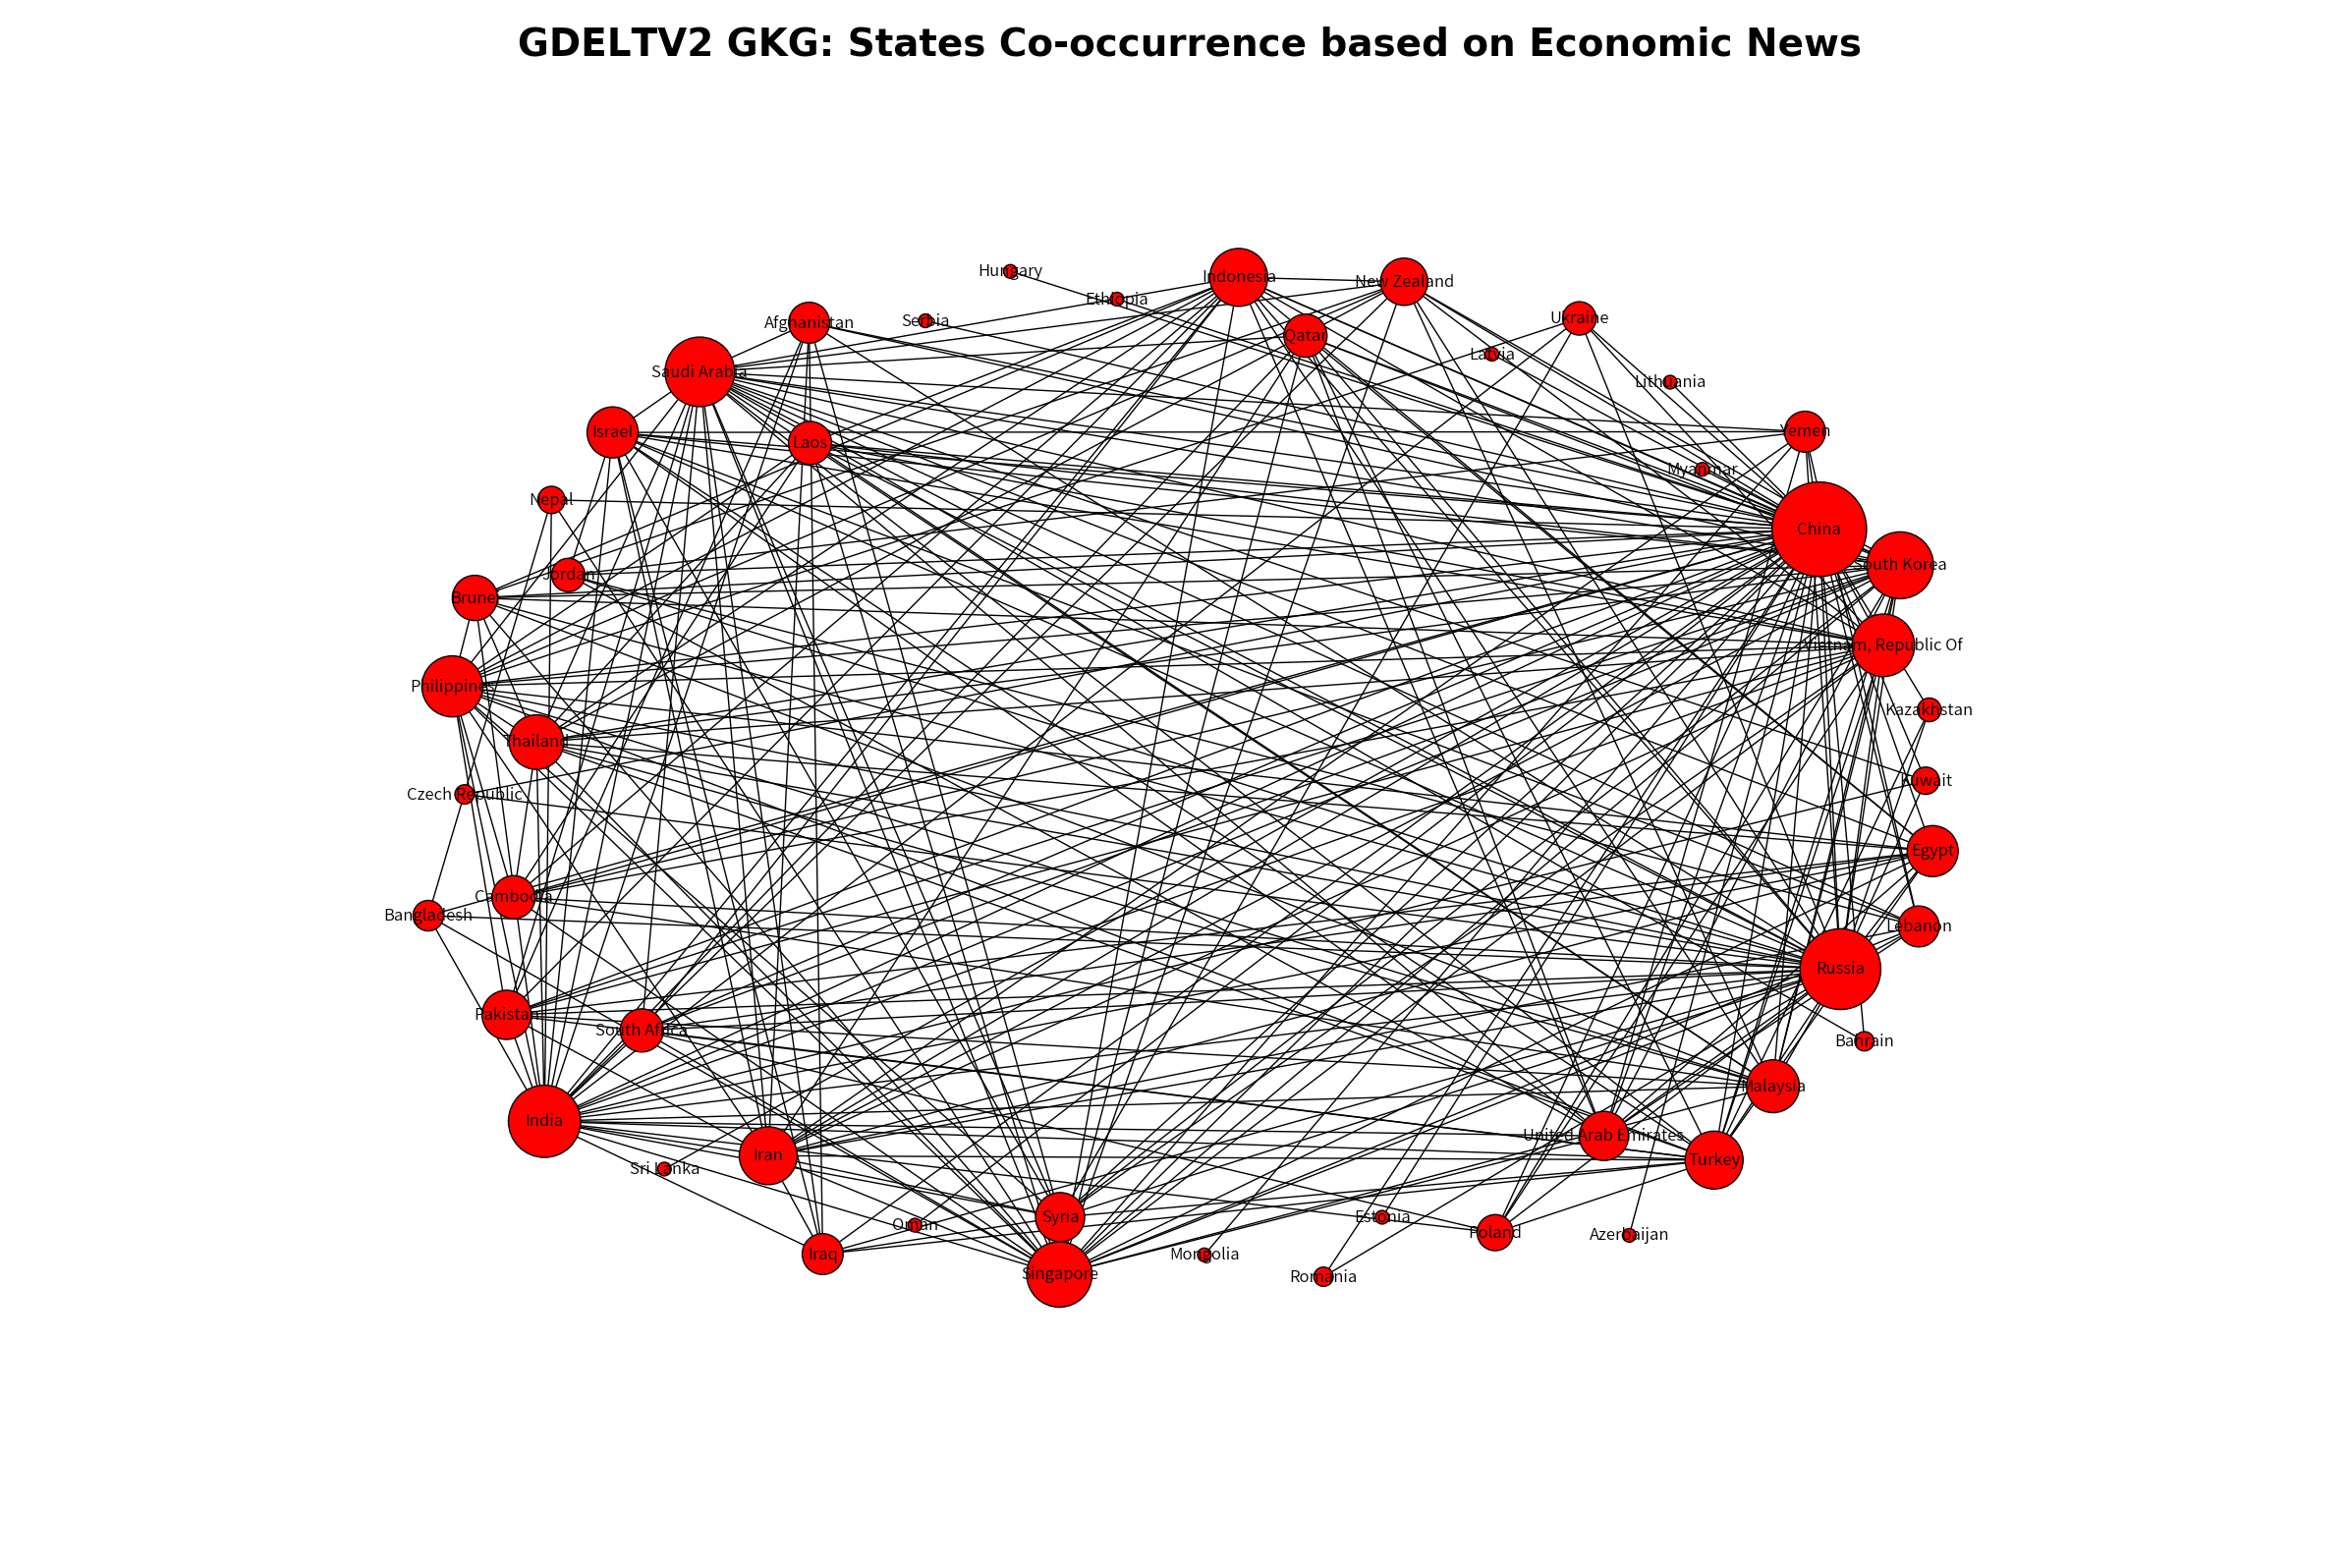

In [19]:
# 获取最大的连通子图
g = nx.Graph()
for r in network.values:
    g.add_edge(r[0], r[1], weight = r[2]/10000)
plt.figure(figsize=(30, 20))
plt.title('GDELTV2 GKG: States Co-occurrence based on Economic News', 
          y = 0.97, 
          fontsize = 28, 
          fontweight = 'bold')
gmax = max(nx.connected_component_subgraphs(g), key=len)
d = dict(nx.degree(gmax))
nx.draw(gmax, 
        nodelist=d.keys(), 
        node_size=[v * 100 for v in d.values()], 
        with_labels = True)

Degree for each node:  
Turkey 	18
Afghanistan 	9
Qatar 	10
Bangladesh 	5
Kuwait 	4
Nepal 	4
Lithuania 	1
Cambodia 	10
Ethiopia 	1
Laos 	10
Czech Republic 	2
Bahrain 	2
Brunei 	11
Saudi Arabia 	26
Iran 	18
Singapore 	23
Jordan 	6
China 	48
Vietnam, Republic Of 	21
Kazakhstan 	3
Philippines 	20
Ukraine 	6
India 	28
Oman 	1
Poland 	7
Indonesia 	18
Israel 	14
Serbia 	1
Latvia 	1
Mongolia 	1
Thailand 	16
Syria 	13
New Zealand 	12
Yemen 	9
Russia 	35
Pakistan 	13
Romania 	2
Iraq 	9
Myanmar 	1
Estonia 	1
South Africa 	10
Egypt 	14
United Arab Emirates 	13
Lebanon 	9
Azerbaijan 	1
Malaysia 	15
Sri Lanka 	1
Hungary 	1
South Korea 	24



Betweenness Centrality for each node:  

Turkey 	0.00982852844555
Afghanistan 	0.000313801643589
Qatar 	0.000328609038715
Bangladesh 	0.000221631205674
Kuwait 	0.0
Nepal 	0.0
Lithuania 	0.0
Cambodia 	0.0
Ethiopia 	0.0
Laos 	0.0
Czech Republic 	0.0
Bahrain 	0.0
Brunei 	0.0
Saudi Arabia 	0.0318446944112
Iran 	0.00711442566496
Singapore 	0.0224172129092
Jordan 	0.

{'Afghanistan': <matplotlib.text.Text at 0x119e553d0>,
 'Azerbaijan': <matplotlib.text.Text at 0x119ed35d0>,
 'Bahrain': <matplotlib.text.Text at 0x119e6ce10>,
 'Bangladesh': <matplotlib.text.Text at 0x119e55c50>,
 'Brunei': <matplotlib.text.Text at 0x119e77290>,
 'Cambodia': <matplotlib.text.Text at 0x119e60cd0>,
 'China': <matplotlib.text.Text at 0x119e84810>,
 'Czech Republic': <matplotlib.text.Text at 0x119e6c9d0>,
 'Egypt': <matplotlib.text.Text at 0x119ec78d0>,
 'Estonia': <matplotlib.text.Text at 0x119ebabd0>,
 'Ethiopia': <matplotlib.text.Text at 0x119e6c150>,
 'Hungary': <matplotlib.text.Text at 0x119e91d90>,
 'India': <matplotlib.text.Text at 0x119ed3190>,
 'Indonesia': <matplotlib.text.Text at 0x11838a8d0>,
 'Iran': <matplotlib.text.Text at 0x119e77b10>,
 'Iraq': <matplotlib.text.Text at 0x119eba790>,
 'Israel': <matplotlib.text.Text at 0x11837dc10>,
 'Jordan': <matplotlib.text.Text at 0x119e843d0>,
 'Kazakhstan': <matplotlib.text.Text at 0x119e910d0>,
 'Kuwait': <matplotlib

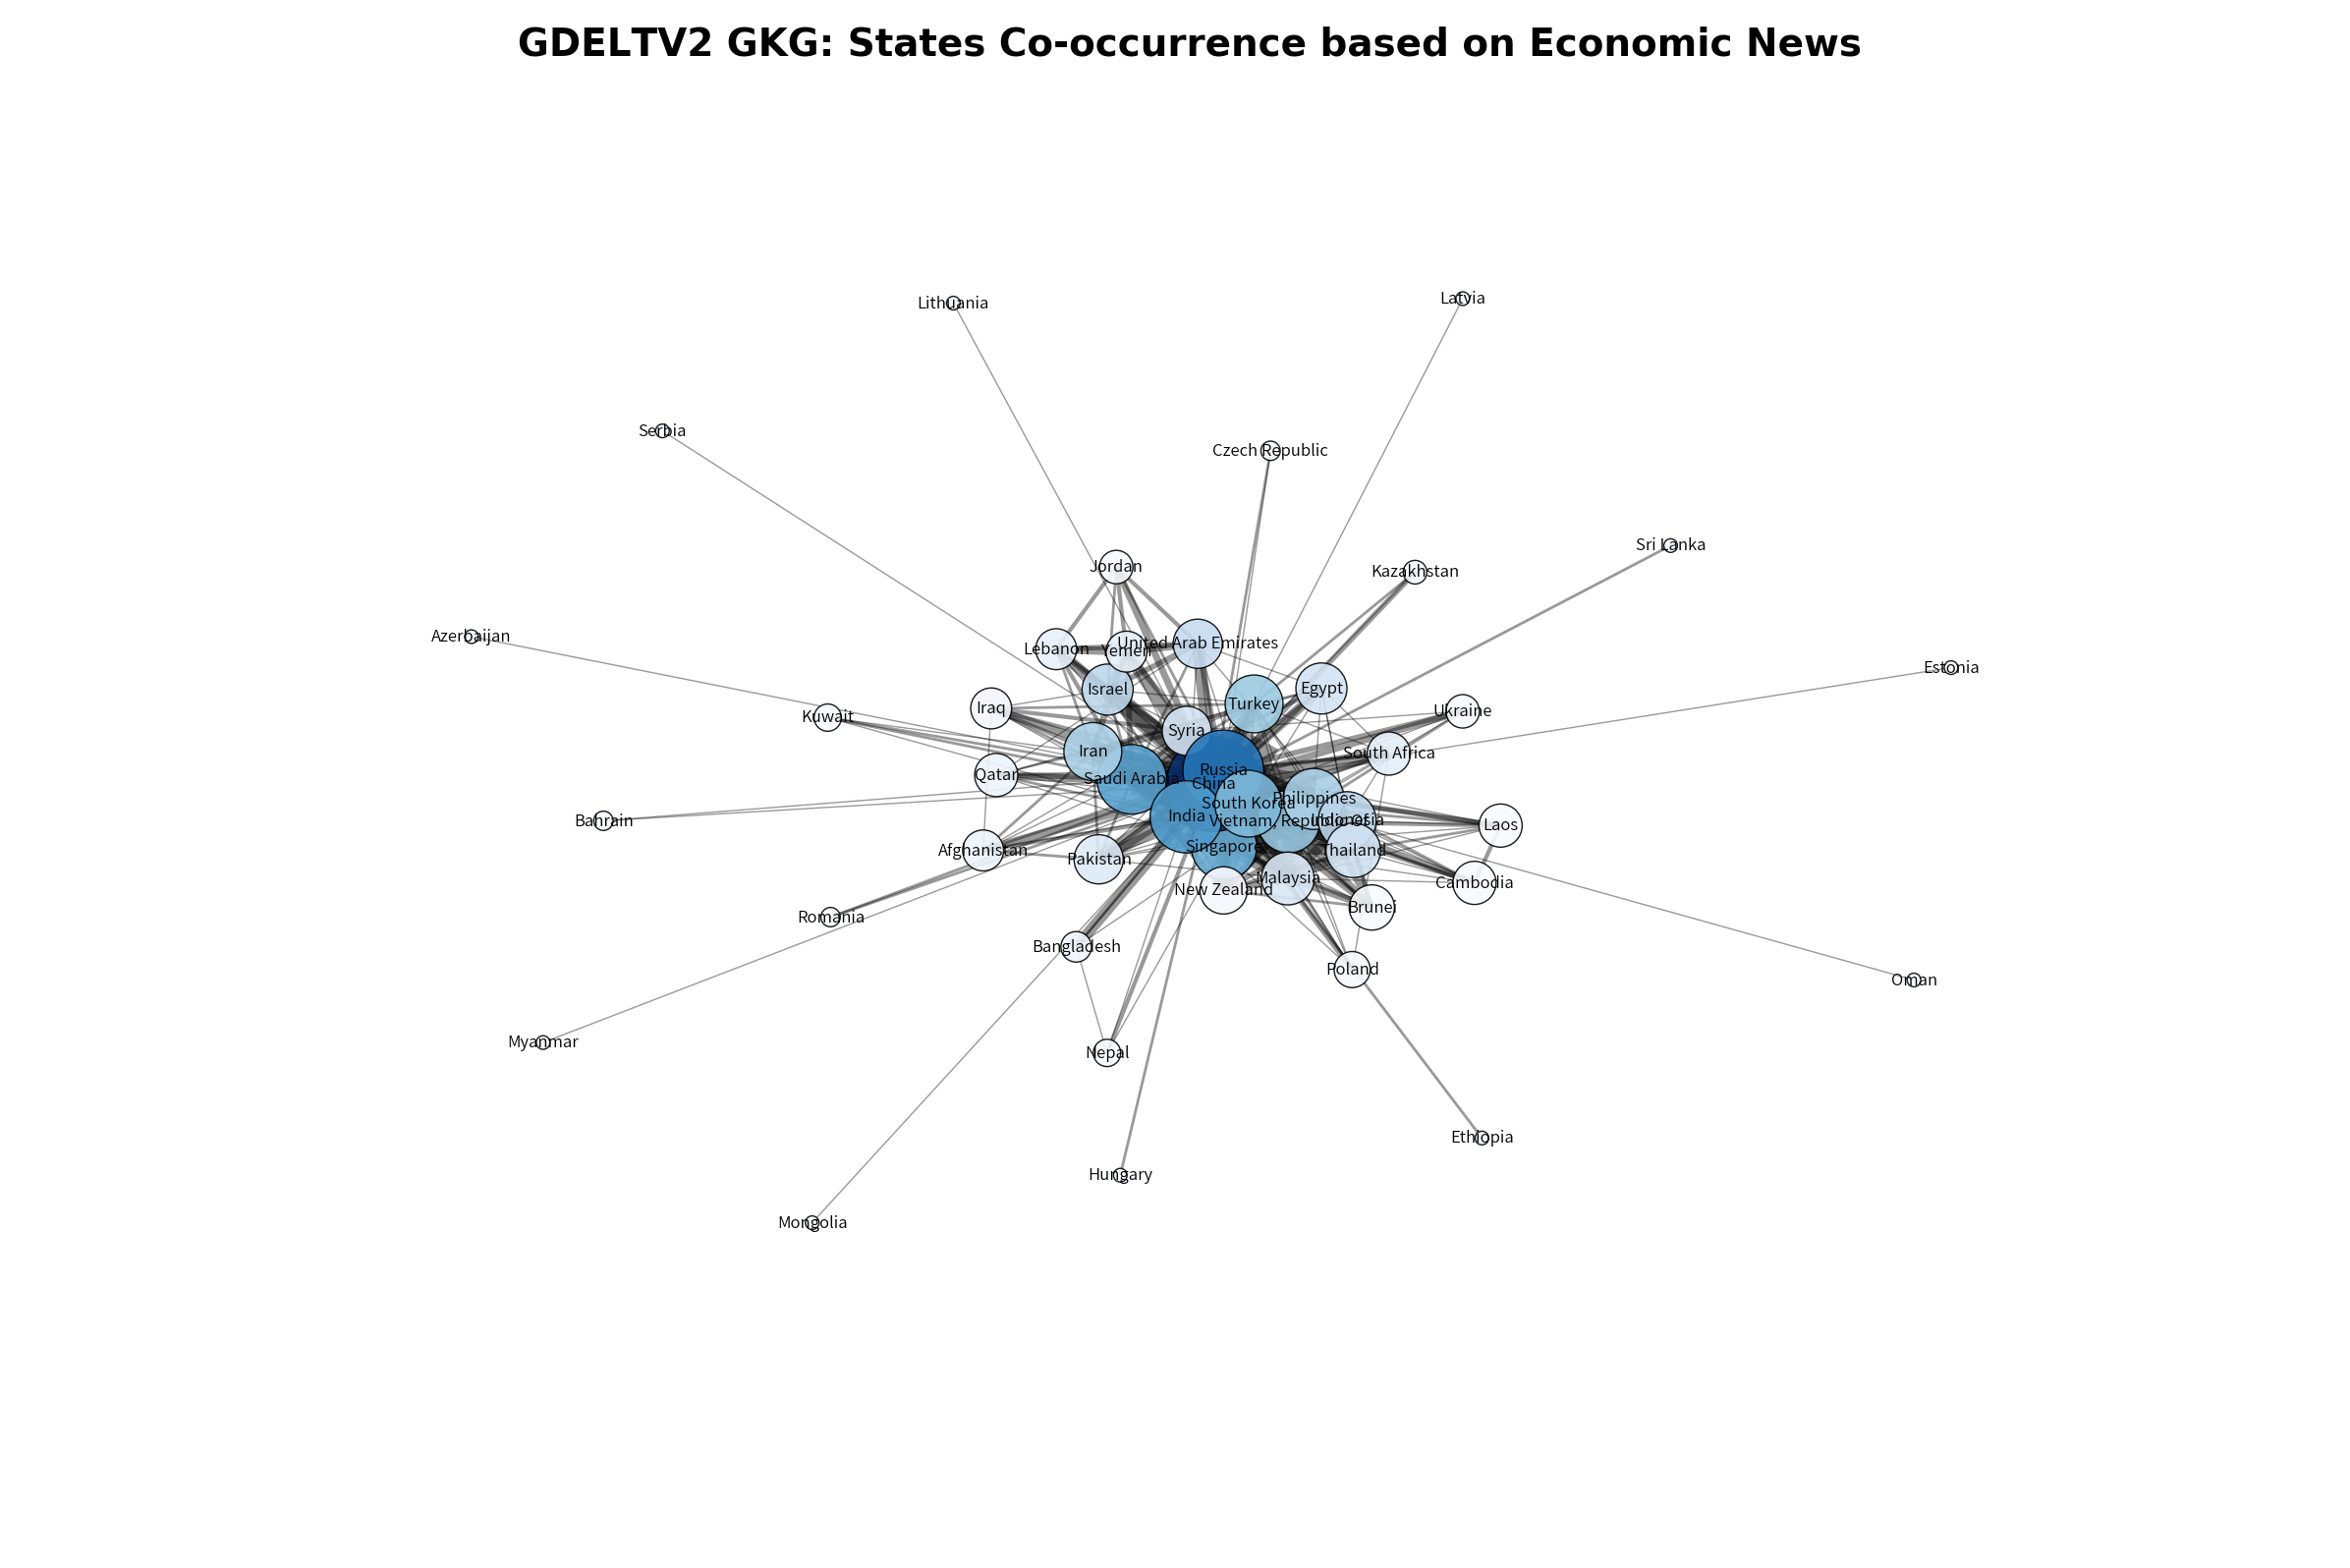

In [20]:
# 对节点、边、标签分别进行渲染
import math

g = nx.Graph()
for r in network.values:
    g.add_edge(r[0], r[1], weight=r[2]/40)

plt.figure(figsize=(30, 20))
plt.title('GDELTV2 GKG: States Co-occurrence based on Economic News', 
          y = 0.97, 
          fontsize = 28, 
          fontweight = 'bold')
cf = plt.gcf()
ax = cf.gca()
ax.set_axis_off()

gmax = max(nx.connected_component_subgraphs(g), key=len)

d = nx.degree(gmax)
d_new = list(d)
# 度指标
print 'Degree for each node: ', '\n',
for i in d_new:
    print i[0], '\t', i[1]

print '\n\n'

b = nx.betweenness_centrality(gmax).items()
b_new = list(b)
# 中介中心性指标
print 'Betweenness Centrality for each node: ', '\n'
for j in b_new:
    print j[0], '\t', j[1]

# 使用spring layout
pos = nx.spring_layout(gmax)

# 针对边的设置
nx.draw_networkx_edges(gmax, 
                       pos, 
                       nodelist=[v[0] for v in b], 
                       node_size=[d[v[0]]*100 for v in b], 
                       with_labels=False, 
                       alpha=0.4, 
                       node_color = [math.log(1+v[1]*1000) for v in b], 
                       cmap=plt.cm.Blues,
                       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

# 针对节点的设置
nx.draw_networkx_nodes(gmax, 
                       pos, 
                       nodelist=[v[0] for v in b], 
                       node_size=[d[v[0]]*100 for v in b], 
                       with_labels=True, 
                       alpha=0.9, 
                       node_color = [math.log(1+v[1]*1000) for v in b], 
                       cmap=plt.cm.Blues, 
                       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

# 针对标签的设置
nx.draw_networkx_labels(gmax, 
                        pos, 
                        nodelist=[v[0] for v in b], 
                        node_size=[d[v[0]]*100 for v in b], 
                        with_labels=True, 
                        node_color = [math.log(1+v[1]*1000) for v in b], 
                        cmap=plt.cm.Blues, 
                        width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

{'Afghanistan': <matplotlib.text.Text at 0x1183dce50>,
 'Azerbaijan': <matplotlib.text.Text at 0x119f7cb90>,
 'Bahrain': <matplotlib.text.Text at 0x119bbf8d0>,
 'Bangladesh': <matplotlib.text.Text at 0x119ba6710>,
 'Brunei': <matplotlib.text.Text at 0x119bbfd10>,
 'Cambodia': <matplotlib.text.Text at 0x119bb3790>,
 'China': <matplotlib.text.Text at 0x119bd72d0>,
 'Czech Republic': <matplotlib.text.Text at 0x119bbf490>,
 'Egypt': <matplotlib.text.Text at 0x119f71e90>,
 'Estonia': <matplotlib.text.Text at 0x119f711d0>,
 'Ethiopia': <matplotlib.text.Text at 0x119bb3bd0>,
 'Hungary': <matplotlib.text.Text at 0x119f47850>,
 'India': <matplotlib.text.Text at 0x119f7c750>,
 'Indonesia': <matplotlib.text.Text at 0x119f52550>,
 'Iran': <matplotlib.text.Text at 0x119bcb5d0>,
 'Iraq': <matplotlib.text.Text at 0x119f5fd50>,
 'Israel': <matplotlib.text.Text at 0x119f52990>,
 'Jordan': <matplotlib.text.Text at 0x119bcbe50>,
 'Kazakhstan': <matplotlib.text.Text at 0x119bd7b50>,
 'Kuwait': <matplotlib

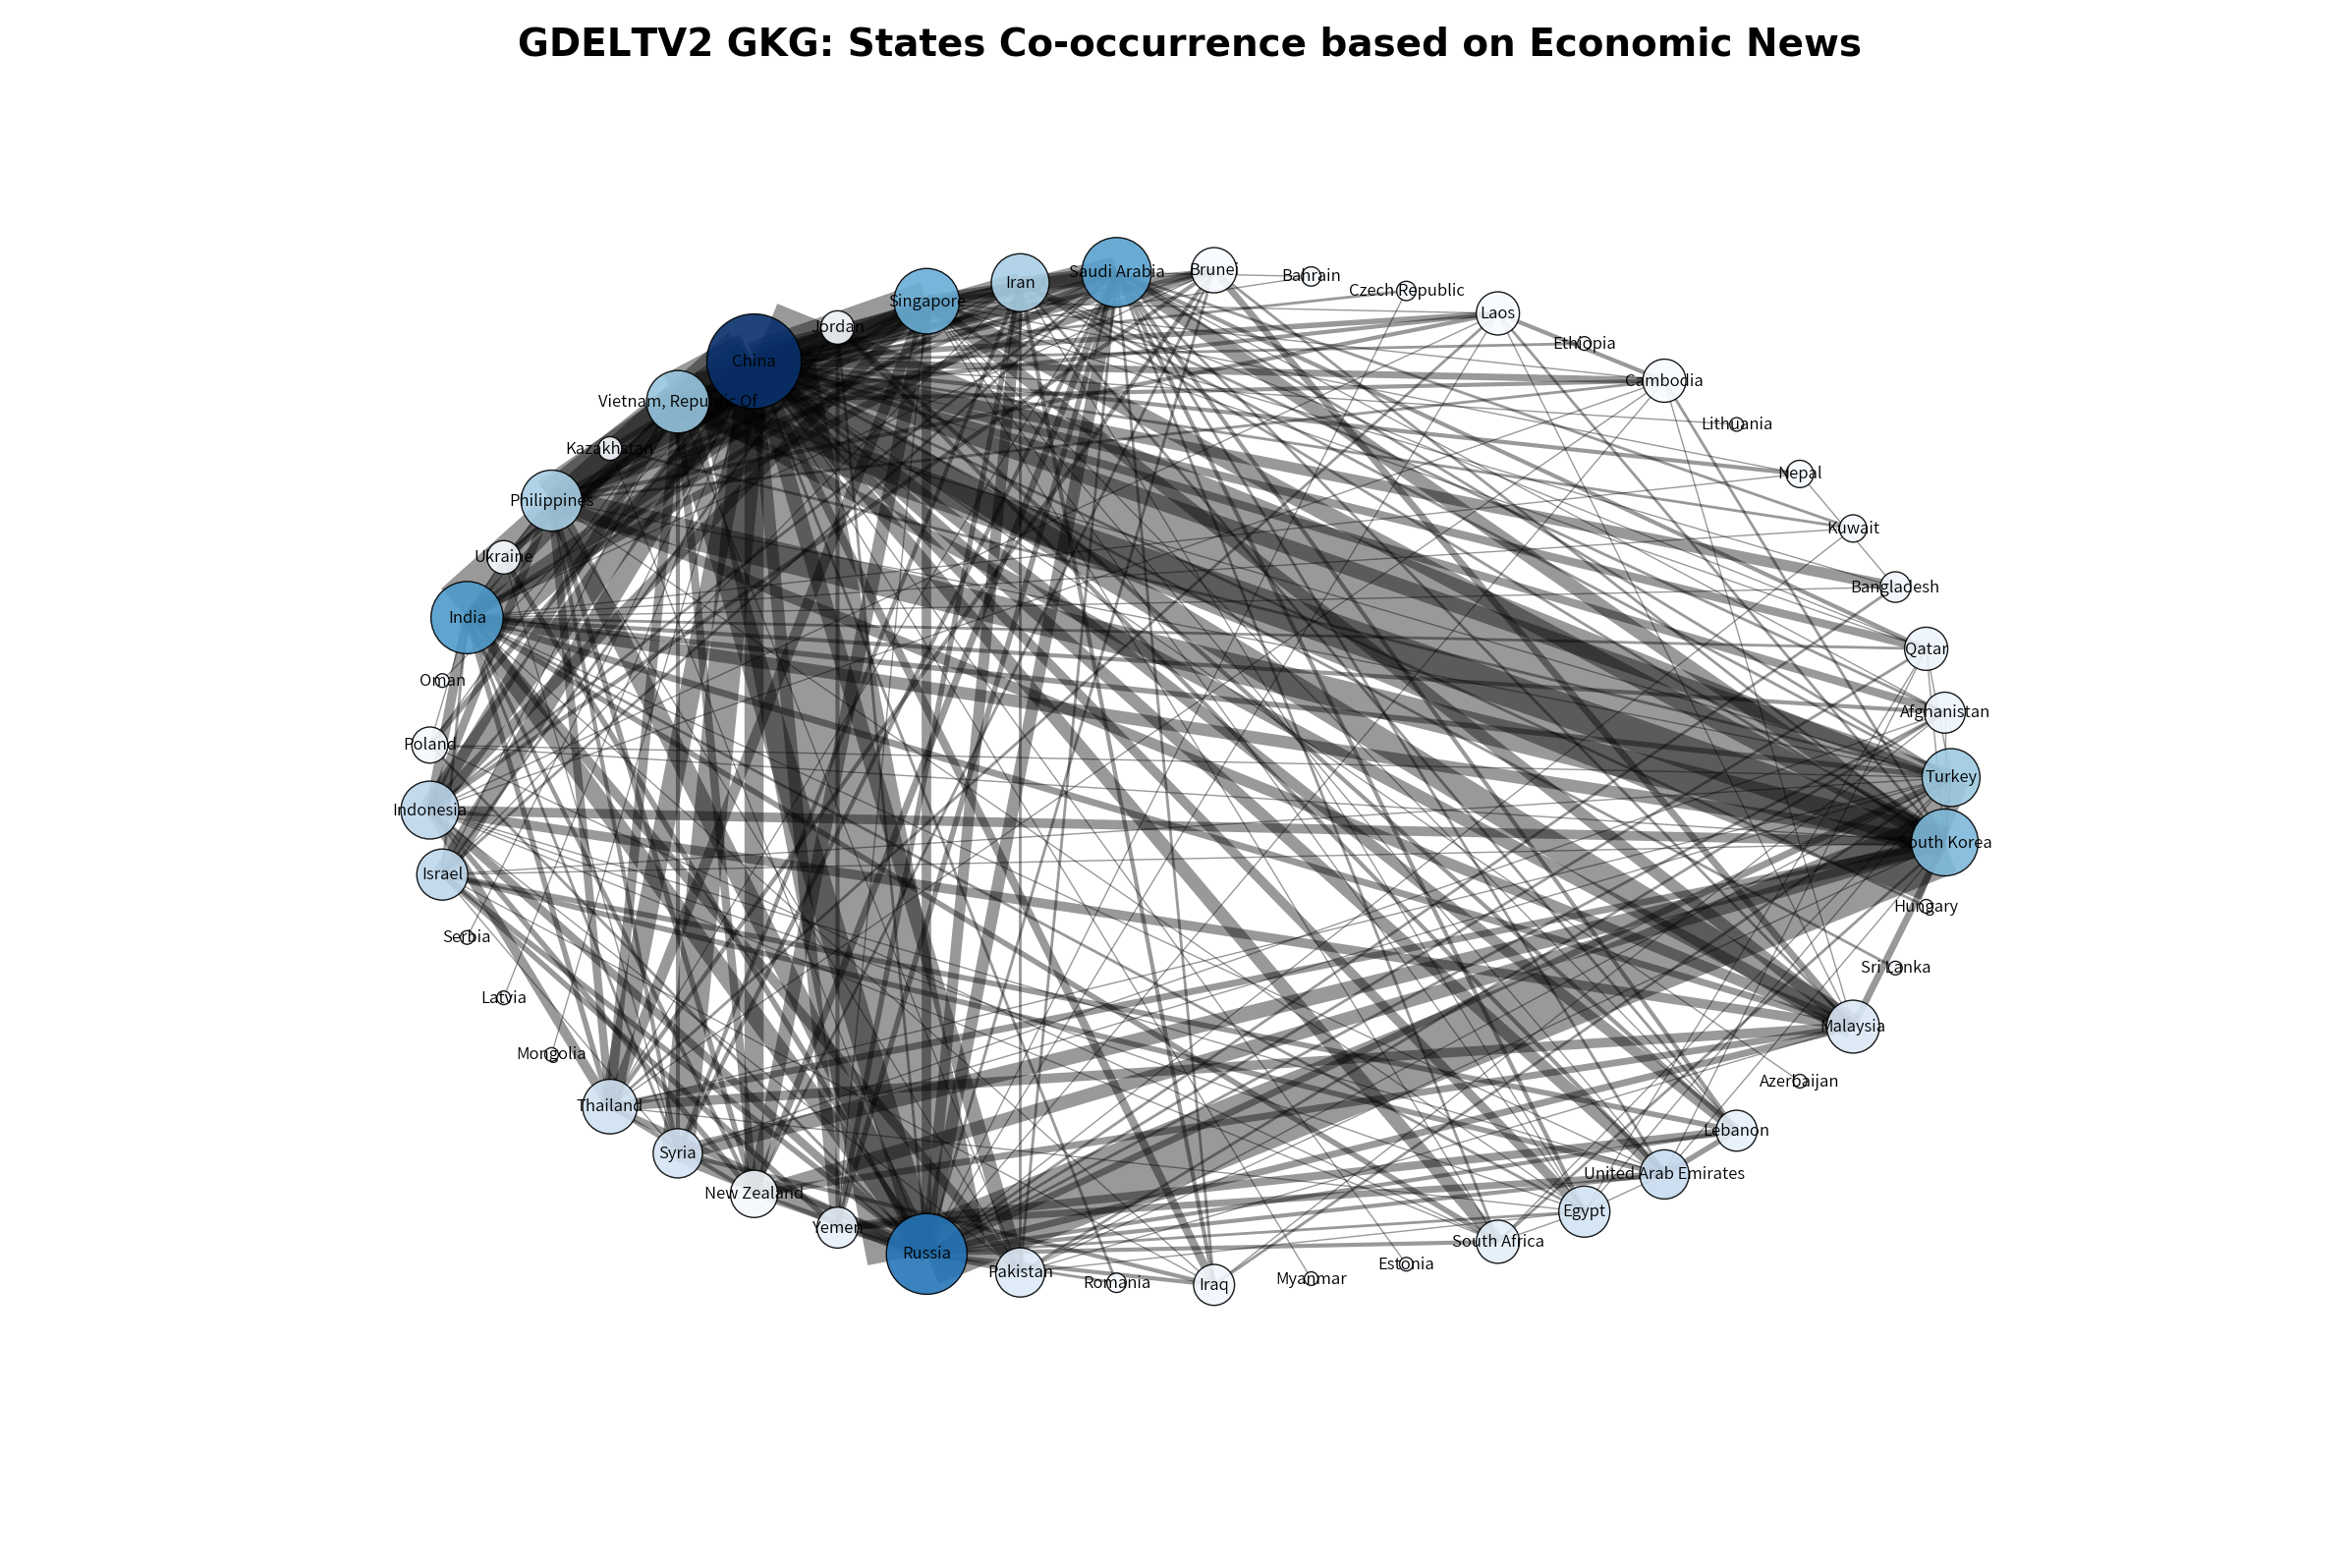

In [21]:
# 从spring layout改为circular layout
g = nx.Graph()
for r in network.values:
    g.add_edge(r[0], r[1], weight=r[2]/40)

plt.figure(figsize=(30, 20))
plt.title('GDELTV2 GKG: States Co-occurrence based on Economic News', 
          y = 0.97, 
          fontsize = 28, 
          fontweight = 'bold')
cf = plt.gcf()
ax = cf.gca()
ax.set_axis_off()

gmax = max(nx.connected_component_subgraphs(g), key=len)

d = nx.degree(gmax)
b = nx.betweenness_centrality(gmax).items()

# 使用spring layout
pos = nx.circular_layout(gmax)

# 针对边的设置
nx.draw_networkx_edges(gmax, 
                       pos, 
                       nodelist=[v[0] for v in b], 
                       node_size=[d[v[0]]*100 for v in b], 
                       with_labels=False, 
                       alpha=0.4, 
                       node_color = [math.log(1+v[1]*1000) for v in b], 
                       cmap=plt.cm.Blues,
                       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

# 针对节点的设置
nx.draw_networkx_nodes(gmax, 
                       pos, 
                       nodelist=[v[0] for v in b], 
                       node_size=[d[v[0]]*100 for v in b], 
                       with_labels=True, 
                       alpha=0.9, 
                       node_color = [math.log(1+v[1]*1000) for v in b], 
                       cmap=plt.cm.Blues, 
                       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

# 针对标签的设置
nx.draw_networkx_labels(gmax, 
                        pos, 
                        nodelist=[v[0] for v in b], 
                        node_size=[d[v[0]]*100 for v in b], 
                        with_labels=True, 
                        node_color = [math.log(1+v[1]*1000) for v in b], 
                        cmap=plt.cm.Blues, 
                        width=[gmax[u][v]['weight'] for u,v in gmax.edges()])